<a href="https://colab.research.google.com/github/smartr99/Git_intro/blob/master/document_classification_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow -y 
!pip install tensorflow==1.15

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 503 kB 55.1 MB/s 
     |████████████████████████████████| 3.8 MB 33.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=b92e1b1e20c83302a44356fffa3dec977866fcc5e2e0363a6ce97712e72f4f3c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard

Getting bert functions

In [ ]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2022-01-25 15:00:31--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

modeling.py         100%[===================>]  37.03K  --.-KB/s    in 0.002s  

2022-01-25 15:00:32 (18.0 MB/s) - ‘modeling.py’ saved [37922/37922]

--2022-01-25 15:00:32--  https://raw.githubusercontent.com/google-research/bert/master/optimization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6258 (6.1K) [text/plain]
Saving to: ‘

### Import necessary libraries

In [ ]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
from datetime import datetime

# BERT
import optimization
import run_classifier
import tokenization
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Checking tensorflow version (should be 1.15)
tf.__version__

'1.15.0'

### Read the training dataset

In [ ]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '/content/drive/MyDrive/datasets/document/' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)


### Get the data as dataframe

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,International films will be given the same p...,entertainment
1,A TV station in the US has refused to show a...,entertainment
2,The sixth and final Star Wars movie may not ...,entertainment
3,"MTV has been criticised for ""incessant sleaz...",entertainment
4,Plans to create a US soap based on the BBC's...,entertainment


Checking the shape of the dataframe

In [ ]:
df.shape

(500, 2)

Checking if null values exist

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

Get unique labels

In [ ]:
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
technologie


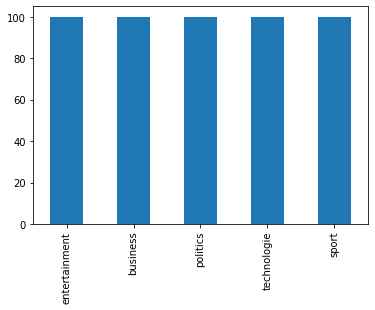

In [ ]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

### Encode the labels into numeric

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,International films will be given the same p...,1
1,A TV station in the US has refused to show a...,1
2,The sixth and final Star Wars movie may not ...,1
3,"MTV has been criticised for ""incessant sleaz...",1
4,Plans to create a US soap based on the BBC's...,1


### Perform preprocessing to text

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

,text,label
0,international films given prominence us films ...,1
1,tv station us refused show controversial new s...,1
2,sixth final star wars movie may suitable young...,1
3,mtv criticised incessant sleaze television ind...,1
4,plans create us soap based bbcs eastenders rep...,1


### Processing text for BERT model



In [ ]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [ ]:
df['text_split'] = df['text'].apply(get_split)
df.head()

,text,label,text_split
0,international films given prominence us films ...,1,[international films given prominence us films...
1,tv station us refused show controversial new s...,1,[tv station us refused show controversial new ...
2,sixth final star wars movie may suitable young...,1,[sixth final star wars movie may suitable youn...
3,mtv criticised incessant sleaze television ind...,1,[mtv criticised incessant sleaze television in...
4,plans create us soap based bbcs eastenders rep...,1,[plans create us soap based bbcs eastenders re...


Setting output directory for BERT

In [ ]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
#         tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


### Split into 80% training and 20% validation

In [ ]:
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label,text_split
0,years clutch oscar nominees least popular yea...,1,[years clutch oscar nominees least popular yea...
1,geek gadget fan next months look like going l...,4,[geek gadget fan next months look like going l...


In [ ]:
# Get labels
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4]

In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label,text_split
0,actor keanu reeves best known role matrix movi...,1,[actor keanu reeves best known role matrix mov...
1,researchers monash swinburne rmit universities...,4,[researchers monash swinburne rmit universitie...


### Check shape of train and validation data

In [ ]:
val.shape, train.shape

((100, 3), (400, 3))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(472, 472, 472)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(123, 123, 123)

### Getting train and validation set as dataframe

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,years clutch oscar nominees least popular year...,1
1,geek gadget fan next months look like going lo...,4
2,transmission speeds megabits per second works ...,4
3,lessons music piracy copyright issues taught s...,1
4,abn amro netherlands largest bank cut jobs res...,0


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,actor keanu reeves best known role matrix movi...,1
1,researchers monash swinburne rmit universities...,4
2,civil servants drastically stepped shredding o...,2
3,britains jason gardener enjoyed double m succe...,3
4,friends actress lisa kudrow play lead role new...,1


In [ ]:
 X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.20, random_state=42)

### Fine tuning the BERT model

The BERT model can be applied for any kind of classification task by fine-tuning it.

#### 1. Preparing the input data, i.e create **InputExample** using the BERT’s constructor.

In [ ]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples


0      <run_classifier.InputExample object at 0x7fb9d...
1      <run_classifier.InputExample object at 0x7fb9d...
2      <run_classifier.InputExample object at 0x7fb9d...
3      <run_classifier.InputExample object at 0x7fb9d...
4      <run_classifier.InputExample object at 0x7fb9d...
                             ...                        
395    <run_classifier.InputExample object at 0x7fb9d...
396    <run_classifier.InputExample object at 0x7fb9d...
397    <run_classifier.InputExample object at 0x7fb9d...
398    <run_classifier.InputExample object at 0x7fb9d...
399    <run_classifier.InputExample object at 0x7fb9d...
Length: 400, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  years clutch oscar nominees least popular  years according box office figures us five nominated best film seen  fewer people movies previous years awards based box office popularity concern ratings televised ceremony dont titanic lord rings think fair say concern us bit said academy executive director bruce davis  million people us seen years nominees compared  million  million recent years last time combined attendance low  amadeus beat killing fields passage india places heart soldiers story best picture  million saw five films last years ceremony attracted highest audience four years viewers tuned see lord ring return king sweep board show reaped biggest audience  titanic took home  oscars film taken m m worldwide ceremony eventually took bn m eyeballs starring movie screen translates eyeballs staring tv screen said paul dergarabedian box office tracker exhibitor relations people like vested interest 

In [ ]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
#     with tf.compat.v1.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['years', 'clutch', 'oscar', 'nominees', 'least', 'popular', 'years', 'according', 'box', 'office', 'figures', 'us', 'five', 'nominated', 'best', 'film', 'seen', 'fewer', 'people', 'movies', 'previous', 'years', 'awards', 'based', 'box', 'office', 'popularity', 'concern', 'ratings', 'televised', 'ceremony', 'don', '##t', 'titanic', 'lord', 'rings', 'think', 'fair', 'say', 'concern', 'us', 'bit', 'said', 'academy', 'executive', 'director', 'bruce', 'davis', 'million', 'people', 'us', 'seen', 'years', 'nominees', 'compared', 'million', 'million', 'recent', 'years', 'last', 'time', 'combined', 'attendance', 'low', 'amadeus', 'beat', 'killing', 'fields', 'passage', 'india', 'places', 'heart', 'soldiers', 'story', 'best', 'picture', 'million', 'saw', 'five', 'films', 'last', 'years', 'ceremony', 'attracted', 'highest', 'audience', 'four', 'years', 'viewers', 'tuned', 'see', 'lord', 'ring', 'return', 'king', 'sweep', 'board', 'show', 're', '##ape', '##d', 'biggest', 'audience', 'titanic', 't

#### 2. Converting the train and validation features to InputFeatures that BERT understands.

In [ ]:
MAX_SEQ_LENGTH = 200

train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 400


INFO:tensorflow:Writing example 0 of 400


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] years clutch oscar nominees least popular years according box office figures us five nominated best film seen fewer people movies previous years awards based box office popularity concern ratings televised ceremony don ##t titanic lord rings think fair say concern us bit said academy executive director bruce davis million people us seen years nominees compared million million recent years last time combined attendance low amadeus beat killing fields passage india places heart soldiers story best picture million saw five films last years ceremony attracted highest audience four years viewers tuned see lord ring return king sweep board show re ##ape ##d biggest audience titanic took home oscar ##s film taken m m worldwide ceremony eventually took bn m eye ##balls starring movie screen translates eye ##balls staring tv screen said paul der ##gara ##bed ##ian box office tracker exhibit ##or relations people like vested interest they ##re watching titanic bn wo

INFO:tensorflow:tokens: [CLS] years clutch oscar nominees least popular years according box office figures us five nominated best film seen fewer people movies previous years awards based box office popularity concern ratings televised ceremony don ##t titanic lord rings think fair say concern us bit said academy executive director bruce davis million people us seen years nominees compared million million recent years last time combined attendance low amadeus beat killing fields passage india places heart soldiers story best picture million saw five films last years ceremony attracted highest audience four years viewers tuned see lord ring return king sweep board show re ##ape ##d biggest audience titanic took home oscar ##s film taken m m worldwide ceremony eventually took bn m eye ##balls starring movie screen translates eye ##balls staring tv screen said paul der ##gara ##bed ##ian box office tracker exhibit ##or relations people like vested interest they ##re watching titanic bn wo

INFO:tensorflow:input_ids: 101 2086 15357 7436 17853 2560 2759 2086 2429 3482 2436 4481 2149 2274 4222 2190 2143 2464 8491 2111 5691 3025 2086 2982 2241 3482 2436 6217 5142 8599 13762 5103 2123 2102 20753 2935 7635 2228 4189 2360 5142 2149 2978 2056 2914 3237 2472 5503 4482 2454 2111 2149 2464 2086 17853 4102 2454 2454 3522 2086 2197 2051 4117 5270 2659 27185 3786 4288 4249 6019 2634 3182 2540 3548 2466 2190 3861 2454 2387 2274 3152 2197 2086 5103 6296 3284 4378 2176 2086 7193 15757 2156 2935 3614 2709 2332 11740 2604 2265 2128 24065 2094 5221 4378 20753 2165 2188 7436 2015 2143 2579 1049 1049 4969 5103 2776 2165 24869 1049 3239 18510 4626 3185 3898 16315 3239 18510 4582 2694 3898 2056 2703 4315 24864 8270 2937 3482 2436 27080 8327 2953 4262 2111 2066 26003 3037 2027 2890 3666 20753 24869 4969 3482 2436 2017 3726 2288 2843 2111 26003 3037 2627 2086 2036 2464 27858 2015 7494 2797 4575 16319 16031 2361 5745 5566 7436 2015 5221 3482 2436 18694 2426 2086 17853 24035 2579 1049 1049 2149 234

INFO:tensorflow:input_ids: 101 2086 15357 7436 17853 2560 2759 2086 2429 3482 2436 4481 2149 2274 4222 2190 2143 2464 8491 2111 5691 3025 2086 2982 2241 3482 2436 6217 5142 8599 13762 5103 2123 2102 20753 2935 7635 2228 4189 2360 5142 2149 2978 2056 2914 3237 2472 5503 4482 2454 2111 2149 2464 2086 17853 4102 2454 2454 3522 2086 2197 2051 4117 5270 2659 27185 3786 4288 4249 6019 2634 3182 2540 3548 2466 2190 3861 2454 2387 2274 3152 2197 2086 5103 6296 3284 4378 2176 2086 7193 15757 2156 2935 3614 2709 2332 11740 2604 2265 2128 24065 2094 5221 4378 20753 2165 2188 7436 2015 2143 2579 1049 1049 4969 5103 2776 2165 24869 1049 3239 18510 4626 3185 3898 16315 3239 18510 4582 2694 3898 2056 2703 4315 24864 8270 2937 3482 2436 27080 8327 2953 4262 2111 2066 26003 3037 2027 2890 3666 20753 24869 4969 3482 2436 2017 3726 2288 2843 2111 26003 3037 2627 2086 2036 2464 27858 2015 7494 2797 4575 16319 16031 2361 5745 5566 7436 2015 5221 3482 2436 18694 2426 2086 17853 24035 2579 1049 1049 2149 234

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] geek ga ##dget fan next months look like going lot fun relentless pace development hit ##ech world rampant competition many sectors particularly among mobile phone firms suggests going good year begin year third ##gen ##eration g mobile phones become in ##es ##cap ##able network launched vo ##da ##fo ##ne launched consumer service november orange followed early december t ##mobile o due launch main result launches likely sl ##ew good deals consumers operators try po ##ach new customers rivals convince existing users trade already extra capacity g networks lets offer good deals voice calls rates probably matched operators shift technology low cost voice calls means operators lose significant chunk revenue show operator believes voice business sustain ill write obituary said ni ##el ransom chief technology officer al ##cate ##l instead operators likely push things g phones video messaging multimedia capabilities already camera phones look set challenge digit

INFO:tensorflow:tokens: [CLS] geek ga ##dget fan next months look like going lot fun relentless pace development hit ##ech world rampant competition many sectors particularly among mobile phone firms suggests going good year begin year third ##gen ##eration g mobile phones become in ##es ##cap ##able network launched vo ##da ##fo ##ne launched consumer service november orange followed early december t ##mobile o due launch main result launches likely sl ##ew good deals consumers operators try po ##ach new customers rivals convince existing users trade already extra capacity g networks lets offer good deals voice calls rates probably matched operators shift technology low cost voice calls means operators lose significant chunk revenue show operator believes voice business sustain ill write obituary said ni ##el ransom chief technology officer al ##cate ##l instead operators likely push things g phones video messaging multimedia capabilities already camera phones look set challenge digit

INFO:tensorflow:input_ids: 101 29294 11721 24291 5470 2279 2706 2298 2066 2183 2843 4569 21660 6393 2458 2718 15937 2088 25883 2971 2116 11105 3391 2426 4684 3042 9786 6083 2183 2204 2095 4088 2095 2353 6914 16754 1043 4684 11640 2468 1999 2229 17695 3085 2897 3390 29536 2850 14876 2638 3390 7325 2326 2281 4589 2628 2220 2285 1056 17751 1051 2349 4888 2364 2765 18989 3497 22889 7974 2204 9144 10390 9224 3046 13433 6776 2047 6304 9169 8054 4493 5198 3119 2525 4469 3977 1043 6125 11082 3749 2204 9144 2376 4455 6165 2763 10349 9224 5670 2974 2659 3465 2376 4455 2965 9224 4558 3278 20000 6599 2265 6872 7164 2376 2449 15770 5665 4339 20815 2056 9152 2884 16540 2708 2974 2961 2632 16280 2140 2612 9224 3497 5245 2477 1043 11640 2678 24732 14959 9859 2525 4950 11640 2298 2275 4119 3617 8629 3497 2663 4599 4800 4168 3654 8197 2595 2884 5733 2175 5096 1043 2673 2126 2227 2971 8361 6786 15536 17848 9949 2974 12992 2951 6726 10898 13164 16313 2015 2566 2117 2573 12103 2661 5982 3497 2609 2866 2015

INFO:tensorflow:input_ids: 101 29294 11721 24291 5470 2279 2706 2298 2066 2183 2843 4569 21660 6393 2458 2718 15937 2088 25883 2971 2116 11105 3391 2426 4684 3042 9786 6083 2183 2204 2095 4088 2095 2353 6914 16754 1043 4684 11640 2468 1999 2229 17695 3085 2897 3390 29536 2850 14876 2638 3390 7325 2326 2281 4589 2628 2220 2285 1056 17751 1051 2349 4888 2364 2765 18989 3497 22889 7974 2204 9144 10390 9224 3046 13433 6776 2047 6304 9169 8054 4493 5198 3119 2525 4469 3977 1043 6125 11082 3749 2204 9144 2376 4455 6165 2763 10349 9224 5670 2974 2659 3465 2376 4455 2965 9224 4558 3278 20000 6599 2265 6872 7164 2376 2449 15770 5665 4339 20815 2056 9152 2884 16540 2708 2974 2961 2632 16280 2140 2612 9224 3497 5245 2477 1043 11640 2678 24732 14959 9859 2525 4950 11640 2298 2275 4119 3617 8629 3497 2663 4599 4800 4168 3654 8197 2595 2884 5733 2175 5096 1043 2673 2126 2227 2971 8361 6786 15536 17848 9949 2974 12992 2951 6726 10898 13164 16313 2015 2566 2117 2573 12103 2661 5982 3497 2609 2866 2015

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] lessons music piracy copyright issues taught secondary school pupils uk lessons aimed year ##old ##s introduce copyright including issues download ##ing internet illegal copying cds role protecting creativity music piracy including illegally swap ##ping music online costs uk music industry millions every year blamed decline worldwide cd sales british music rights b ##m ##r formed represent interests songwriters composers worked education experts put together learning pack songwriter guy chambers worked stars including robbie williams thrown support behind scheme said well educating children music piracy would also protect young people planning career music industry un ##sc ##rup ##ulous individuals debate london launch scheme chambers said think important young people receive practical engaging learning schools lessons give insight creative industries work help possible future careers education pack already requested secondary schools aimed giving children

INFO:tensorflow:tokens: [CLS] lessons music piracy copyright issues taught secondary school pupils uk lessons aimed year ##old ##s introduce copyright including issues download ##ing internet illegal copying cds role protecting creativity music piracy including illegally swap ##ping music online costs uk music industry millions every year blamed decline worldwide cd sales british music rights b ##m ##r formed represent interests songwriters composers worked education experts put together learning pack songwriter guy chambers worked stars including robbie williams thrown support behind scheme said well educating children music piracy would also protect young people planning career music industry un ##sc ##rup ##ulous individuals debate london launch scheme chambers said think important young people receive practical engaging learning schools lessons give insight creative industries work help possible future careers education pack already requested secondary schools aimed giving children

INFO:tensorflow:input_ids: 101 8220 2189 24386 9385 3314 4036 3905 2082 7391 2866 8220 6461 2095 11614 2015 8970 9385 2164 3314 8816 2075 4274 6206 24731 14340 2535 8650 14842 2189 24386 2164 17800 19948 4691 2189 3784 5366 2866 2189 3068 8817 2296 2095 11248 6689 4969 3729 4341 2329 2189 2916 1038 2213 2099 2719 5050 5426 20602 9929 2499 2495 8519 2404 2362 4083 5308 6009 3124 8477 2499 3340 2164 12289 3766 6908 2490 2369 5679 2056 2092 25088 2336 2189 24386 2052 2036 4047 2402 2111 4041 2476 2189 3068 4895 11020 21531 16203 3633 5981 2414 4888 5679 8477 2056 2228 2590 2402 2111 4374 6742 11973 4083 2816 8220 2507 12369 5541 6088 2147 2393 2825 2925 10922 2495 5308 2525 7303 3905 2816 6461 3228 2336 4824 9385 7189 2189 3068 2036 6570 2336 5197 25335 13275 7073 2367 10922 2189 3068 3391 3617 2287 8863 10930 18684 3363 2236 3208 2329 2189 2916 2409 4035 2739 2816 6933 7692 2393 16957 7391 3314 5679 5331 1038 2213 2869 4847 3643 2189 3049 2036 6153 8453 5063 15994 2015 3571 9692 11420 32

INFO:tensorflow:input_ids: 101 8220 2189 24386 9385 3314 4036 3905 2082 7391 2866 8220 6461 2095 11614 2015 8970 9385 2164 3314 8816 2075 4274 6206 24731 14340 2535 8650 14842 2189 24386 2164 17800 19948 4691 2189 3784 5366 2866 2189 3068 8817 2296 2095 11248 6689 4969 3729 4341 2329 2189 2916 1038 2213 2099 2719 5050 5426 20602 9929 2499 2495 8519 2404 2362 4083 5308 6009 3124 8477 2499 3340 2164 12289 3766 6908 2490 2369 5679 2056 2092 25088 2336 2189 24386 2052 2036 4047 2402 2111 4041 2476 2189 3068 4895 11020 21531 16203 3633 5981 2414 4888 5679 8477 2056 2228 2590 2402 2111 4374 6742 11973 4083 2816 8220 2507 12369 5541 6088 2147 2393 2825 2925 10922 2495 5308 2525 7303 3905 2816 6461 3228 2336 4824 9385 7189 2189 3068 2036 6570 2336 5197 25335 13275 7073 2367 10922 2189 3068 3391 3617 2287 8863 10930 18684 3363 2236 3208 2329 2189 2916 2409 4035 2739 2816 6933 7692 2393 16957 7391 3314 5679 5331 1038 2213 2869 4847 3643 2189 3049 2036 6153 8453 5063 15994 2015 3571 9692 11420 32

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ab ##n am ##ro netherlands largest bank cut jobs result falling profits cuts amount ##ing banks workforce result one ##off charge m euros bn jobs go investment banking go human resources respectively ab ##n am ##ro third large european bank announce cut ##backs past month following deutsche bank credit sui ##sse group profit ##ability hit fall mortgage lending united states banks largest single market following recent interest rate rises ab ##n am ##ros operations netherlands united kingdom hardest hit jobs also lost us accounted profit first half across operations americas asia ##pac ##ific regions restructuring designed improve efficiency reducing administrative costs increasing focus client service bank said course rise net income year operating profits set fall fall us revenues ab ##n am ##ro currently staff get profit growth coming years lower costs shed ##ding jobs makes total sense ivo ge ##ij ##sen analyst bank o ##yen ##s van ee ##gh ##en told blo

INFO:tensorflow:tokens: [CLS] ab ##n am ##ro netherlands largest bank cut jobs result falling profits cuts amount ##ing banks workforce result one ##off charge m euros bn jobs go investment banking go human resources respectively ab ##n am ##ro third large european bank announce cut ##backs past month following deutsche bank credit sui ##sse group profit ##ability hit fall mortgage lending united states banks largest single market following recent interest rate rises ab ##n am ##ros operations netherlands united kingdom hardest hit jobs also lost us accounted profit first half across operations americas asia ##pac ##ific regions restructuring designed improve efficiency reducing administrative costs increasing focus client service bank said course rise net income year operating profits set fall fall us revenues ab ##n am ##ro currently staff get profit growth coming years lower costs shed ##ding jobs makes total sense ivo ge ##ij ##sen analyst bank o ##yen ##s van ee ##gh ##en told blo

INFO:tensorflow:input_ids: 101 11113 2078 2572 3217 4549 2922 2924 3013 5841 2765 4634 11372 7659 3815 2075 5085 14877 2765 2028 7245 3715 1049 19329 24869 5841 2175 5211 8169 2175 2529 4219 4414 11113 2078 2572 3217 2353 2312 2647 2924 14970 3013 12221 2627 3204 2206 11605 2924 4923 24086 11393 2177 5618 8010 2718 2991 14344 18435 2142 2163 5085 2922 2309 3006 2206 3522 3037 3446 9466 11113 2078 2572 7352 3136 4549 2142 2983 18263 2718 5841 2036 2439 2149 14729 5618 2034 2431 2408 3136 10925 4021 19498 18513 4655 18322 2881 5335 8122 8161 3831 5366 4852 3579 7396 2326 2924 2056 2607 4125 5658 3318 2095 4082 11372 2275 2991 2991 2149 12594 11113 2078 2572 3217 2747 3095 2131 5618 3930 2746 2086 2896 5366 8328 4667 5841 3084 2561 3168 28346 16216 28418 5054 12941 2924 1051 20684 2015 3158 25212 5603 2368 2409 22950 2885 2015 2877 5085 4025 2275 2558 2128 7913 12680 3672 11605 2924 2056 3041 3204 2052 5547 2446 14877 2116 5841 2439 4923 24086 11393 2034 3731 102 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 11113 2078 2572 3217 4549 2922 2924 3013 5841 2765 4634 11372 7659 3815 2075 5085 14877 2765 2028 7245 3715 1049 19329 24869 5841 2175 5211 8169 2175 2529 4219 4414 11113 2078 2572 3217 2353 2312 2647 2924 14970 3013 12221 2627 3204 2206 11605 2924 4923 24086 11393 2177 5618 8010 2718 2991 14344 18435 2142 2163 5085 2922 2309 3006 2206 3522 3037 3446 9466 11113 2078 2572 7352 3136 4549 2142 2983 18263 2718 5841 2036 2439 2149 14729 5618 2034 2431 2408 3136 10925 4021 19498 18513 4655 18322 2881 5335 8122 8161 3831 5366 4852 3579 7396 2326 2924 2056 2607 4125 5658 3318 2095 4082 11372 2275 2991 2991 2149 12594 11113 2078 2572 3217 2747 3095 2131 5618 3930 2746 2086 2896 5366 8328 4667 5841 3084 2561 3168 28346 16216 28418 5054 12941 2924 1051 20684 2015 3158 25212 5603 2368 2409 22950 2885 2015 2877 5085 4025 2275 2558 2128 7913 12680 3672 11605 2924 2056 3041 3204 2052 5547 2446 14877 2116 5841 2439 4923 24086 11393 2034 3731 102 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] indian telecommunications firm turned lasers help overcome problems setting voice data networks country tata tel ##ese ##r ##vic ##es using lasers make link customers offices core network laser bridges work across distances km set much faster cable connections months lasers helped firm set networks locations particular geography getting permission dig ground lay pipes bit task said mr r sri ##dhar ##an vice president networks tata heavy traffic layout ground mean digging uniquely difficult said locations said permission dig roads lay cables impossible get said far easier secure permission putting networking hardware roofs led chennai ##base ##d tata turn equipment uses lasers make final mile leap tata ##s core network premises customers light ##point ##e laser bridges work distances km used route voice data businesses backbone network hardware works pairs beam data air form laser pulses laser bridges route data speeds gb ##ps times faster kb ##ps broadband

INFO:tensorflow:tokens: [CLS] indian telecommunications firm turned lasers help overcome problems setting voice data networks country tata tel ##ese ##r ##vic ##es using lasers make link customers offices core network laser bridges work across distances km set much faster cable connections months lasers helped firm set networks locations particular geography getting permission dig ground lay pipes bit task said mr r sri ##dhar ##an vice president networks tata heavy traffic layout ground mean digging uniquely difficult said locations said permission dig roads lay cables impossible get said far easier secure permission putting networking hardware roofs led chennai ##base ##d tata turn equipment uses lasers make final mile leap tata ##s core network premises customers light ##point ##e laser bridges work distances km used route voice data businesses backbone network hardware works pairs beam data air form laser pulses laser bridges route data speeds gb ##ps times faster kb ##ps broadband

INFO:tensorflow:input_ids: 101 2796 12108 3813 2357 23965 2393 9462 3471 4292 2376 2951 6125 2406 23236 10093 6810 2099 7903 2229 2478 23965 2191 4957 6304 4822 4563 2897 9138 7346 2147 2408 12103 2463 2275 2172 5514 5830 7264 2706 23965 3271 3813 2275 6125 5269 3327 10505 2893 6656 10667 2598 3913 12432 2978 4708 2056 2720 1054 5185 25632 2319 3580 2343 6125 23236 3082 4026 9621 2598 2812 10443 20640 3697 2056 5269 2056 6656 10667 4925 3913 15196 5263 2131 2056 2521 6082 5851 6656 5128 14048 8051 15753 2419 12249 15058 2094 23236 2735 3941 3594 23965 2191 2345 3542 11679 23236 2015 4563 2897 10345 6304 2422 8400 2063 9138 7346 2147 12103 2463 2109 2799 2376 2951 5661 21505 2897 8051 2573 7689 7504 2951 2250 2433 9138 23894 9138 7346 2799 2951 10898 16351 4523 2335 5514 21677 4523 19595 4434 23236 2770 8051 10754 10898 16914 4523 23965 2036 7812 2634 4785 3391 7218 4542 3446 2210 2659 6684 2412 9666 6292 2056 3182 4542 3082 9666 2691 9138 6971 5998 5441 2204 4434 10898 9138 6971 2036 2

INFO:tensorflow:input_ids: 101 2796 12108 3813 2357 23965 2393 9462 3471 4292 2376 2951 6125 2406 23236 10093 6810 2099 7903 2229 2478 23965 2191 4957 6304 4822 4563 2897 9138 7346 2147 2408 12103 2463 2275 2172 5514 5830 7264 2706 23965 3271 3813 2275 6125 5269 3327 10505 2893 6656 10667 2598 3913 12432 2978 4708 2056 2720 1054 5185 25632 2319 3580 2343 6125 23236 3082 4026 9621 2598 2812 10443 20640 3697 2056 5269 2056 6656 10667 4925 3913 15196 5263 2131 2056 2521 6082 5851 6656 5128 14048 8051 15753 2419 12249 15058 2094 23236 2735 3941 3594 23965 2191 2345 3542 11679 23236 2015 4563 2897 10345 6304 2422 8400 2063 9138 7346 2147 12103 2463 2109 2799 2376 2951 5661 21505 2897 8051 2573 7689 7504 2951 2250 2433 9138 23894 9138 7346 2799 2951 10898 16351 4523 2335 5514 21677 4523 19595 4434 23236 2770 8051 10754 10898 16914 4523 23965 2036 7812 2634 4785 3391 7218 4542 3446 2210 2659 6684 2412 9666 6292 2056 3182 4542 3082 9666 2691 9138 6971 5998 5441 2204 4434 10898 9138 6971 2036 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] actor ke ##anu reeves best known role matrix movies awarded star prestigious hollywood walk fame year ##old attended un ##ve ##iling star mother patricia thanked inspiring become actor years old asked mom ok actor reeves said said whatever want star th embedded pavement hollywood boulevard actor born lebanese capital beirut also spoke dropped school pursue acting career hollywood calling said got car british racing green volvo holes floor bricks holding seats young man full hopes dreams reeves first found fame teen comedy bill ted ##s excellent adventure went combine blockbuster ##s speed devils advocate matrix series smaller films including private idaho recently seen something ##s gotta give alongside jack nicholson diane ke ##aton next film supernatural thriller constantine released us later month opens uk march [SEP]


INFO:tensorflow:tokens: [CLS] actor ke ##anu reeves best known role matrix movies awarded star prestigious hollywood walk fame year ##old attended un ##ve ##iling star mother patricia thanked inspiring become actor years old asked mom ok actor reeves said said whatever want star th embedded pavement hollywood boulevard actor born lebanese capital beirut also spoke dropped school pursue acting career hollywood calling said got car british racing green volvo holes floor bricks holding seats young man full hopes dreams reeves first found fame teen comedy bill ted ##s excellent adventure went combine blockbuster ##s speed devils advocate matrix series smaller films including private idaho recently seen something ##s gotta give alongside jack nicholson diane ke ##aton next film supernatural thriller constantine released us later month opens uk march [SEP]


INFO:tensorflow:input_ids: 101 3364 17710 24076 17891 2190 2124 2535 8185 5691 3018 2732 8919 5365 3328 4476 2095 11614 3230 4895 3726 16281 2732 2388 10717 15583 18988 2468 3364 2086 2214 2356 3566 7929 3364 17891 2056 2056 3649 2215 2732 16215 11157 14271 5365 8459 3364 2141 12592 3007 15335 2036 3764 3333 2082 7323 3772 2476 5365 4214 2056 2288 2482 2329 3868 2665 21074 8198 2723 14219 3173 4272 2402 2158 2440 8069 5544 17891 2034 2179 4476 9458 4038 3021 6945 2015 6581 6172 2253 11506 27858 2015 3177 13664 8175 8185 2186 3760 3152 2164 2797 9795 3728 2464 2242 2015 10657 2507 4077 2990 16955 12082 17710 22436 2279 2143 11189 10874 12790 2207 2149 2101 3204 7480 2866 2233 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3364 17710 24076 17891 2190 2124 2535 8185 5691 3018 2732 8919 5365 3328 4476 2095 11614 3230 4895 3726 16281 2732 2388 10717 15583 18988 2468 3364 2086 2214 2356 3566 7929 3364 17891 2056 2056 3649 2215 2732 16215 11157 14271 5365 8459 3364 2141 12592 3007 15335 2036 3764 3333 2082 7323 3772 2476 5365 4214 2056 2288 2482 2329 3868 2665 21074 8198 2723 14219 3173 4272 2402 2158 2440 8069 5544 17891 2034 2179 4476 9458 4038 3021 6945 2015 6581 6172 2253 11506 27858 2015 3177 13664 8175 8185 2186 3760 3152 2164 2797 9795 3728 2464 2242 2015 10657 2507 4077 2990 16955 12082 17710 22436 2279 2143 11189 10874 12790 2207 2149 2101 3204 7480 2866 2233 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] researchers mona ##sh sw ##in ##burn ##e rm ##it universities successfully tested recorded australia ##s fastest internet data speed world single optical chip capable download ##ing high definition movies split second published prestigious journal nature communications findings potential fast ##tra ##ck next years australia ##s telecommunications capacity also possibility home ##gr ##own technology rolled across world technology capacity support highs ##peed internet connections million households melbourne australia time billions across world peak periods used new device replaces lasers one single piece equipment known micro ##comb smaller lighter existing telecommunications hardware planted load ##test ##ed using existing infrastructure mirrors used n ##bn first time micro ##comb used field trial possesses highest amount data produced single optical chip currently getting sneak ##pe ##ak infrastructure internet hold two three years time due unprecedented

INFO:tensorflow:tokens: [CLS] researchers mona ##sh sw ##in ##burn ##e rm ##it universities successfully tested recorded australia ##s fastest internet data speed world single optical chip capable download ##ing high definition movies split second published prestigious journal nature communications findings potential fast ##tra ##ck next years australia ##s telecommunications capacity also possibility home ##gr ##own technology rolled across world technology capacity support highs ##peed internet connections million households melbourne australia time billions across world peak periods used new device replaces lasers one single piece equipment known micro ##comb smaller lighter existing telecommunications hardware planted load ##test ##ed using existing infrastructure mirrors used n ##bn first time micro ##comb used field trial possesses highest amount data produced single optical chip currently getting sneak ##pe ##ak infrastructure internet hold two three years time due unprecedented

INFO:tensorflow:input_ids: 101 6950 13813 4095 25430 2378 8022 2063 28549 4183 5534 5147 7718 2680 2660 2015 7915 4274 2951 3177 2088 2309 9380 9090 5214 8816 2075 2152 6210 5691 3975 2117 2405 8919 3485 3267 4806 9556 4022 3435 6494 3600 2279 2086 2660 2015 12108 3977 2036 6061 2188 16523 12384 2974 4565 2408 2088 2974 3977 2490 26836 25599 4274 7264 2454 3911 4940 2660 2051 25501 2408 2088 4672 6993 2109 2047 5080 20736 23965 2028 2309 3538 3941 2124 12702 18274 3760 9442 4493 12108 8051 8461 7170 22199 2098 2478 4493 6502 13536 2109 1050 24700 2034 2051 12702 18274 2109 2492 3979 14882 3284 3815 2951 2550 2309 9380 9090 2747 2893 13583 5051 4817 6502 4274 2907 2048 2093 2086 2051 2349 15741 2193 2111 2478 4274 6556 2147 2591 6026 11058 2428 4760 2149 2342 2583 4094 3977 4274 7264 2056 2852 3021 2522 29566 5521 5624 4215 3166 2817 9162 5992 3274 3001 3330 13813 4095 2118 2470 16691 3754 16662 2525 2598 4283 1050 24700 2622 21505 4806 6125 2925 2057 3726 2764 2242 26743 3468 3113 2925

INFO:tensorflow:input_ids: 101 6950 13813 4095 25430 2378 8022 2063 28549 4183 5534 5147 7718 2680 2660 2015 7915 4274 2951 3177 2088 2309 9380 9090 5214 8816 2075 2152 6210 5691 3975 2117 2405 8919 3485 3267 4806 9556 4022 3435 6494 3600 2279 2086 2660 2015 12108 3977 2036 6061 2188 16523 12384 2974 4565 2408 2088 2974 3977 2490 26836 25599 4274 7264 2454 3911 4940 2660 2051 25501 2408 2088 4672 6993 2109 2047 5080 20736 23965 2028 2309 3538 3941 2124 12702 18274 3760 9442 4493 12108 8051 8461 7170 22199 2098 2478 4493 6502 13536 2109 1050 24700 2034 2051 12702 18274 2109 2492 3979 14882 3284 3815 2951 2550 2309 9380 9090 2747 2893 13583 5051 4817 6502 4274 2907 2048 2093 2086 2051 2349 15741 2193 2111 2478 4274 6556 2147 2591 6026 11058 2428 4760 2149 2342 2583 4094 3977 4274 7264 2056 2852 3021 2522 29566 5521 5624 4215 3166 2817 9162 5992 3274 3001 3330 13813 4095 2118 2470 16691 3754 16662 2525 2598 4283 1050 24700 2622 21505 4806 6125 2925 2057 3726 2764 2242 26743 3468 3113 2925

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] civil servants drastically stepped sh ##red ##ding official documents figures compiled tori ##es suggest government departments doubled number documents shredded ahead freedom information acts implementation january departments defence environment trade increased file destruction said following rules governing public records tori ##es want information commissioner investigate freedom information act first time give members public access government records previously kept secret years bbc political correspondent james hardy said prospect outsiders poking noses inner workings whitehall appeared causing ji ##tters among mandarin ##s liberal democrat alan beit ##h chairs select committee monitors department constitutional affairs said claims true whitehall acting entirely spirit new act information commissioner select committee keep issue close scrutiny fellow li ##b dem norman baker said episode painted un ##fl ##atter ##ing picture inner workings government 

INFO:tensorflow:tokens: [CLS] civil servants drastically stepped sh ##red ##ding official documents figures compiled tori ##es suggest government departments doubled number documents shredded ahead freedom information acts implementation january departments defence environment trade increased file destruction said following rules governing public records tori ##es want information commissioner investigate freedom information act first time give members public access government records previously kept secret years bbc political correspondent james hardy said prospect outsiders poking noses inner workings whitehall appeared causing ji ##tters among mandarin ##s liberal democrat alan beit ##h chairs select committee monitors department constitutional affairs said claims true whitehall acting entirely spirit new act information commissioner select committee keep issue close scrutiny fellow li ##b dem norman baker said episode painted un ##fl ##atter ##ing picture inner workings government 

INFO:tensorflow:input_ids: 101 2942 8858 21040 3706 14021 5596 4667 2880 5491 4481 9227 23413 2229 6592 2231 7640 11515 2193 5491 29022 3805 4071 2592 4490 7375 2254 7640 4721 4044 3119 3445 5371 6215 2056 2206 3513 8677 2270 2636 23413 2229 2215 2592 5849 8556 4071 2592 2552 2034 2051 2507 2372 2270 3229 2231 2636 3130 2921 3595 2086 4035 2576 11370 2508 9532 2056 9824 22361 21603 27518 5110 24884 28361 2596 4786 10147 24168 2426 15831 2015 4314 7672 5070 28236 2232 8397 7276 2837 15410 2533 6543 3821 2056 4447 2995 28361 3772 4498 4382 2047 2552 2592 5849 7276 2837 2562 3277 2485 17423 3507 5622 2497 17183 5879 6243 2056 2792 4993 4895 10258 20097 2075 3861 5110 24884 2231 3154 6867 3988 12024 2330 2231 2357 2969 8043 6455 22330 8713 2964 2852 6426 4572 4603 14056 5239 2436 2056 3603 4121 16264 14021 5596 4667 2186 5768 6998 2533 2147 22024 3908 3053 6764 2197 2095 2176 2086 3283 2552 2979 2193 6764 3908 3757 4721 7640 4044 2833 3541 3821 3119 3068 2036 13763 12099 2852 4572 2170 481

INFO:tensorflow:input_ids: 101 2942 8858 21040 3706 14021 5596 4667 2880 5491 4481 9227 23413 2229 6592 2231 7640 11515 2193 5491 29022 3805 4071 2592 4490 7375 2254 7640 4721 4044 3119 3445 5371 6215 2056 2206 3513 8677 2270 2636 23413 2229 2215 2592 5849 8556 4071 2592 2552 2034 2051 2507 2372 2270 3229 2231 2636 3130 2921 3595 2086 4035 2576 11370 2508 9532 2056 9824 22361 21603 27518 5110 24884 28361 2596 4786 10147 24168 2426 15831 2015 4314 7672 5070 28236 2232 8397 7276 2837 15410 2533 6543 3821 2056 4447 2995 28361 3772 4498 4382 2047 2552 2592 5849 7276 2837 2562 3277 2485 17423 3507 5622 2497 17183 5879 6243 2056 2792 4993 4895 10258 20097 2075 3861 5110 24884 2231 3154 6867 3988 12024 2330 2231 2357 2969 8043 6455 22330 8713 2964 2852 6426 4572 4603 14056 5239 2436 2056 3603 4121 16264 14021 5596 4667 2186 5768 6998 2533 2147 22024 3908 3053 6764 2197 2095 2176 2086 3283 2552 2979 2193 6764 3908 3757 4721 7640 4044 2833 3541 3821 3119 3068 2036 13763 12099 2852 4572 2170 481

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] britain ##s jason gardener enjoyed double m success glasgow first competitive outing since m relay gold athens olympics gardener cruise ##d home ahead sc ##ot nick smith win invitational race norwich union international recovered poor start second race beat sw ##ede daniel per ##sson italy ##s luca verde ##cchi ##a times seconds well short american maurice greene ##s m world record sec ##s hard record break believe iv ##e trained well said world indoor champion hopes get closer mark season important come make sure got maximum points last race olympic final lot expectation needed sharpe ##n get race fitness im excited next couple months double olympic champion marked first appearance home soil since winning m m gold athens victory third success britain edged russia ##s olga fed ##oro ##va sweden ##s jenny ka ##ll ##ur win women ##s m race sec ##s mad ##ua ##ka unable repeat feat m finishing fourth took win russia year ##old also missed podium place x ##m re

INFO:tensorflow:tokens: [CLS] britain ##s jason gardener enjoyed double m success glasgow first competitive outing since m relay gold athens olympics gardener cruise ##d home ahead sc ##ot nick smith win invitational race norwich union international recovered poor start second race beat sw ##ede daniel per ##sson italy ##s luca verde ##cchi ##a times seconds well short american maurice greene ##s m world record sec ##s hard record break believe iv ##e trained well said world indoor champion hopes get closer mark season important come make sure got maximum points last race olympic final lot expectation needed sharpe ##n get race fitness im excited next couple months double olympic champion marked first appearance home soil since winning m m gold athens victory third success britain edged russia ##s olga fed ##oro ##va sweden ##s jenny ka ##ll ##ur win women ##s m race sec ##s mad ##ua ##ka unable repeat feat m finishing fourth took win russia year ##old also missed podium place x ##m re

INFO:tensorflow:input_ids: 101 3725 2015 4463 19785 5632 3313 1049 3112 6785 2034 6975 26256 2144 1049 8846 2751 7571 3783 19785 8592 2094 2188 3805 8040 4140 4172 3044 2663 20129 2679 12634 2586 2248 6757 3532 2707 2117 2679 3786 25430 14728 3817 2566 7092 3304 2015 15604 16184 25955 2050 2335 3823 2092 2460 2137 7994 11006 2015 1049 2088 2501 10819 2015 2524 2501 3338 2903 4921 2063 4738 2092 2056 2088 7169 3410 8069 2131 3553 2928 2161 2590 2272 2191 2469 2288 4555 2685 2197 2679 4386 2345 2843 17626 2734 22147 2078 2131 2679 10516 10047 7568 2279 3232 2706 3313 4386 3410 4417 2034 3311 2188 5800 2144 3045 1049 1049 2751 7571 3377 2353 3112 3725 13011 3607 2015 15585 7349 14604 3567 4701 2015 8437 10556 3363 3126 2663 2308 2015 1049 2679 10819 2015 5506 6692 2912 4039 9377 8658 1049 5131 2959 2165 2663 3607 2095 11614 2036 4771 14502 2173 1060 2213 8846 2329 8530 2234 2959 3607 4292 2047 2088 7169 2501 2275 5963 12323 3779 4265 28667 3126 24413 2067 4544 2146 5376 3607 3116 2345 256

INFO:tensorflow:input_ids: 101 3725 2015 4463 19785 5632 3313 1049 3112 6785 2034 6975 26256 2144 1049 8846 2751 7571 3783 19785 8592 2094 2188 3805 8040 4140 4172 3044 2663 20129 2679 12634 2586 2248 6757 3532 2707 2117 2679 3786 25430 14728 3817 2566 7092 3304 2015 15604 16184 25955 2050 2335 3823 2092 2460 2137 7994 11006 2015 1049 2088 2501 10819 2015 2524 2501 3338 2903 4921 2063 4738 2092 2056 2088 7169 3410 8069 2131 3553 2928 2161 2590 2272 2191 2469 2288 4555 2685 2197 2679 4386 2345 2843 17626 2734 22147 2078 2131 2679 10516 10047 7568 2279 3232 2706 3313 4386 3410 4417 2034 3311 2188 5800 2144 3045 1049 1049 2751 7571 3377 2353 3112 3725 13011 3607 2015 15585 7349 14604 3567 4701 2015 8437 10556 3363 3126 2663 2308 2015 1049 2679 10819 2015 5506 6692 2912 4039 9377 8658 1049 5131 2959 2165 2663 3607 2095 11614 2036 4771 14502 2173 1060 2213 8846 2329 8530 2234 2959 3607 4292 2047 2088 7169 2501 2275 5963 12323 3779 4265 28667 3126 24413 2067 4544 2146 5376 3607 3116 2345 256

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] friends actress lisa ku ##dro ##w play lead role new series one ##time sitcom star according hollywood reporter thirteen episodes comeback commissioned cable channel hbo home hits sex city ku ##dro ##w played phoebe friends cow ##rot ##e pilot episode also act executive producer hbo looking next big comedy hit since sex city drew close us february comeback first minute comedy series channel picked since sex city drew end six ##year ##run friends ended year run nbc network may attention ##s turned projects six individual stars would pursue matt le ##bla ##nc starring friends spin ##off sitcom charting joey ##s fortunes los angeles pursue ##s acting career jennifer an ##isto ##n rachel long ##run ##ning show enjoyed series successful film appearances projects pipeline court ##ene ##y cox ar ##quette monica working drama project along husband david ar ##quette hbo called rise fall taylor kennedy matthew perry played chandler appeared west end stage film begin

INFO:tensorflow:tokens: [CLS] friends actress lisa ku ##dro ##w play lead role new series one ##time sitcom star according hollywood reporter thirteen episodes comeback commissioned cable channel hbo home hits sex city ku ##dro ##w played phoebe friends cow ##rot ##e pilot episode also act executive producer hbo looking next big comedy hit since sex city drew close us february comeback first minute comedy series channel picked since sex city drew end six ##year ##run friends ended year run nbc network may attention ##s turned projects six individual stars would pursue matt le ##bla ##nc starring friends spin ##off sitcom charting joey ##s fortunes los angeles pursue ##s acting career jennifer an ##isto ##n rachel long ##run ##ning show enjoyed series successful film appearances projects pipeline court ##ene ##y cox ar ##quette monica working drama project along husband david ar ##quette hbo called rise fall taylor kennedy matthew perry played chandler appeared west end stage film begin

INFO:tensorflow:input_ids: 101 2814 3883 7059 13970 22196 2860 2377 2599 2535 2047 2186 2028 7292 13130 2732 2429 5365 6398 7093 4178 12845 4837 5830 3149 14633 2188 4978 3348 2103 13970 22196 2860 2209 18188 2814 11190 21709 2063 4405 2792 2036 2552 3237 3135 14633 2559 2279 2502 4038 2718 2144 3348 2103 3881 2485 2149 2337 12845 2034 3371 4038 2186 3149 3856 2144 3348 2103 3881 2203 2416 29100 15532 2814 3092 2095 2448 6788 2897 2089 3086 2015 2357 3934 2416 3265 3340 2052 7323 4717 3393 28522 12273 4626 2814 6714 7245 13130 17918 9558 2015 18023 3050 3349 7323 2015 3772 2476 7673 2019 20483 2078 5586 2146 15532 5582 2265 5632 2186 3144 2143 3922 3934 13117 2457 8625 2100 9574 12098 29416 9018 2551 3689 2622 2247 3129 2585 12098 29416 14633 2170 4125 2991 4202 5817 5487 6890 2209 13814 2596 2225 2203 2754 2143 2927 9866 2747 2537 2585 8040 2232 9148 15810 5811 2856 2051 2814 2036 2499 9558 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2814 3883 7059 13970 22196 2860 2377 2599 2535 2047 2186 2028 7292 13130 2732 2429 5365 6398 7093 4178 12845 4837 5830 3149 14633 2188 4978 3348 2103 13970 22196 2860 2209 18188 2814 11190 21709 2063 4405 2792 2036 2552 3237 3135 14633 2559 2279 2502 4038 2718 2144 3348 2103 3881 2485 2149 2337 12845 2034 3371 4038 2186 3149 3856 2144 3348 2103 3881 2203 2416 29100 15532 2814 3092 2095 2448 6788 2897 2089 3086 2015 2357 3934 2416 3265 3340 2052 7323 4717 3393 28522 12273 4626 2814 6714 7245 13130 17918 9558 2015 18023 3050 3349 7323 2015 3772 2476 7673 2019 20483 2078 5586 2146 15532 5582 2265 5632 2186 3144 2143 3922 3934 13117 2457 8625 2100 9574 12098 29416 9018 2551 3689 2622 2247 3129 2585 12098 29416 14633 2170 4125 2991 4202 5817 5487 6890 2209 13814 2596 2225 2203 2754 2143 2927 9866 2747 2537 2585 8040 2232 9148 15810 5811 2856 2051 2814 2036 2499 9558 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  years clutch oscar nominees least popular  years according box office figures us five nominated best film seen  fewer people movies previous years awards based box office popularity concern ratings televised ceremony dont titanic lord rings think fair say concern us bit said academy executive director bruce davis  million people us seen years nominees compared  million  million recent years last time combined attendance low  amadeus beat killing fields passage india places heart soldiers story best picture  million saw five films last years ceremony attracted highest audience four years viewers tuned see lord ring return king sweep board show reaped biggest audience  titanic took home  oscars film taken m m worldwide ceremony eventually took bn m eyeballs starring movie screen translates eyeballs staring tv screen said paul dergarabedian box office tracker exhibitor relations people like vested interest theyre watching titanic bn worldwide box office youve got lot people ve

### Creating prediction model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]
    # with tf.Session() as sess:
    output_layer1 = bert_outputs["pooled_output"]
    # output_layer1 = 999
    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs, output_layer1)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)   
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)  
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)

                return {
                    "eval_accuracy": accuracy,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg,
                    }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                  loss=loss,
                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs, output_layer) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels,
              'pooled_output': output_layer
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)


(25, 5)

### Initializing the model and the estimator


In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb9c8930690>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb9c8930690>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

### Training the model

In [ ]:
# Training
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:loss = 1.6035335, step = 1


INFO:tensorflow:loss = 1.6035335, step = 1


INFO:tensorflow:Saving checkpoints for 25 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 25 into /bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.8287116.


INFO:tensorflow:Loss for final step: 0.8287116.


Training took time  0:13:55.509685


### Validation

In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-01-25T15:27:03Z


INFO:tensorflow:Starting evaluation at 2022-01-25T15:27:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-25


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-25


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2022-01-25-15:28:12


INFO:tensorflow:Finished evaluation at 2022-01-25-15:28:12


INFO:tensorflow:Saving dict for global step 25: eval_accuracy = 0.99, false_negatives = 0.0, false_positives = 1.0, global_step = 25, loss = 0.634384, true_negatives = 15.0, true_positives = 84.0


INFO:tensorflow:Saving dict for global step 25: eval_accuracy = 0.99, false_negatives = 0.0, false_positives = 1.0, global_step = 25, loss = 0.634384, true_negatives = 15.0, true_positives = 84.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25: /bert_news_category/model.ckpt-25


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25: /bert_news_category/model.ckpt-25


{'eval_accuracy': 0.99,
 'false_negatives': 0.0,
 'false_positives': 1.0,
 'global_step': 25,
 'loss': 0.634384,
 'true_negatives': 15.0,
 'true_positives': 84.0}

In [ ]:
# Importing the dependancies
from sklearn import metrics
# Predicted values
a = "false_neg"
b = "true_neg"
c = "false_pos"
d = "true_pos"


y_pred = [a,c]
# Actual values
y_act = [b,d ]
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(y_act, y_pred))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred))

[[0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]]
              precision    recall  f1-score   support

   false_neg       0.00      0.00      0.00       0.0
   false_pos       0.00      0.00      0.00       0.0
    true_neg       0.00      0.00      0.00       1.0
    true_pos       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1